# Estudio clientela gimnasio

Este proyecto busca analizar el comportamiento de los clientes de un gimnasio con el fin de identificar los factores que influyen en la cancelación del servicio. A través de técnicas de análisis exploratorio, modelos de predicción y segmentación por clústeres, se estudian patrones de uso, características demográficas y variables contractuales.

In [14]:
#LIBRERIAS
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## Paso 1

In [2]:
data = pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
# Mostrar primeras filas
print(data.head())
# Información general
print(data.info())
# dimensiones: filas x columnas
print(data.shape)

   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0  

In [4]:
# Verificar valores ausentes
print(data.isna().sum())


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


## Paso 2

In [5]:
# Verificar valores ausentes
print(data.isna().sum())

# Estadísticas descriptivas
data.describe().T

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


- No se observa presencia de datos ausentes.
- En cuanto a las variables observamos lo siguiente:
    - Near_Location: 85% vive o trabaja en un vecindario donde se encuentra un gimnasio.
    - Partner: ~49% son empleados de empresas asociadas.
    - Promo_friends: solo ~31% llegó con promo de amigos.
    - Phone: casi todos dieron su número (90%).
    - Group_visits: 41% asiste a clases grupales.
    - Age: edad media de 29 años.
    - Contract_period: promedio 4.6 meses.
    - Lifetime: en promedio 3.7 meses en el gimnasio, pero con outliers máx. 31 meses.
    - Avg_additional_charges_total: 147, pero con outliers max 552.
    - Avg_class_frequency_total: =  ~1.9 visitas/semana.
    - Avg_class_frequency_current_month: = ~1.77 visitas/semana.
    - Variable objetivo (Churn): ~26.5% de los clientes cancelaron.


In [6]:
# Agrupar por churn y calcular la media de cada característica
mean_churn = data.groupby('Churn').mean()
mean_churn

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


- Near_Location: Los clientes que se fueron no suelen vivir o trabajar en vecindarios con gimnasios en ellos (0.77 vs 0.87).
- Partner: La proporción de clientes asociados a empresas es menor entre los que se fueron (0.36 vs 0.53).
- Promo_friends: Muy pocos clientes que se fueron se unieron mediante promociones de amigos (0.18 vs 0.35).
- Contract_period y Month_to_end_contract: Los que se fueron tenían contratos más cortos y menos meses restantes (1.73 vs 5.75 y 1.66 vs 5.28).
- Lifetime: Los clientes que se fueron llevaban menos tiempo en el gimnasio (0.99 vs 4.71 meses).
- Frecuencia de clases: Los que se quedaron tenían mayor frecuencia de asistencia tanto histórica como actual (2.02 vs 1.47 y 2.03 vs 1.04).
- Edad: Los que se fueron son ligeramente más jóvenes (27 vs 30 años).
- Gasto adicional: Menor entre los que se fueron (115 vs 158).

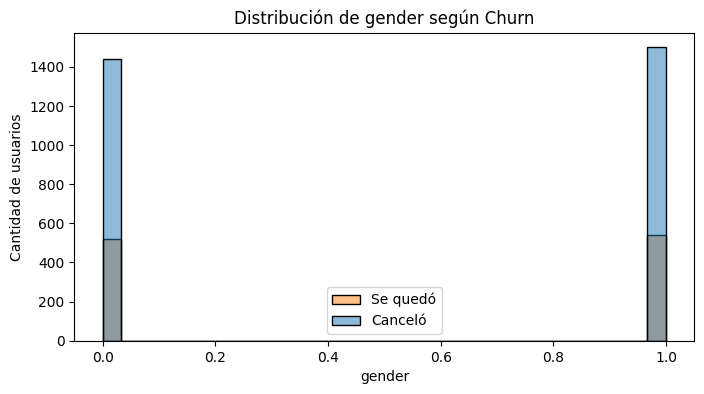

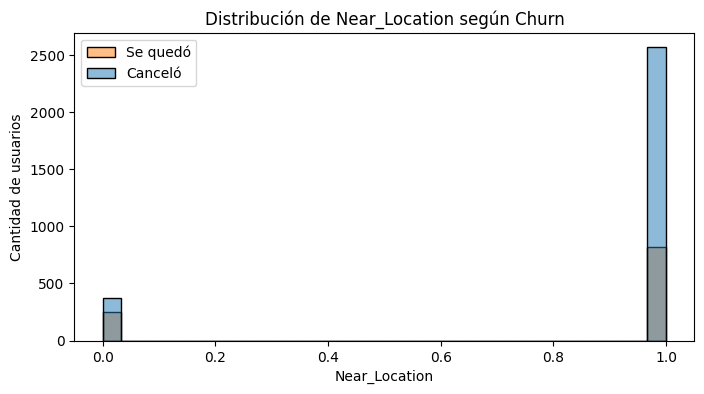

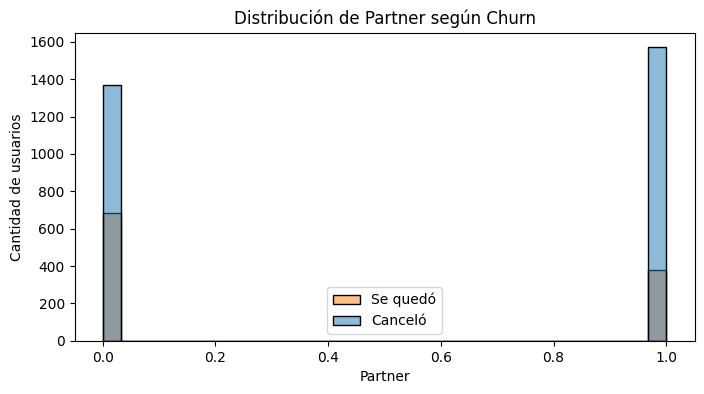

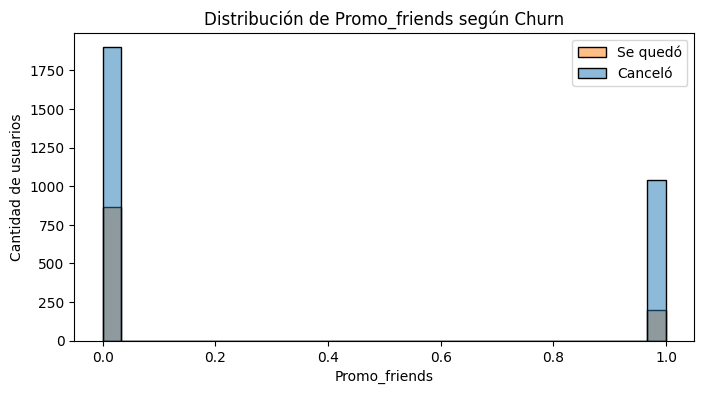

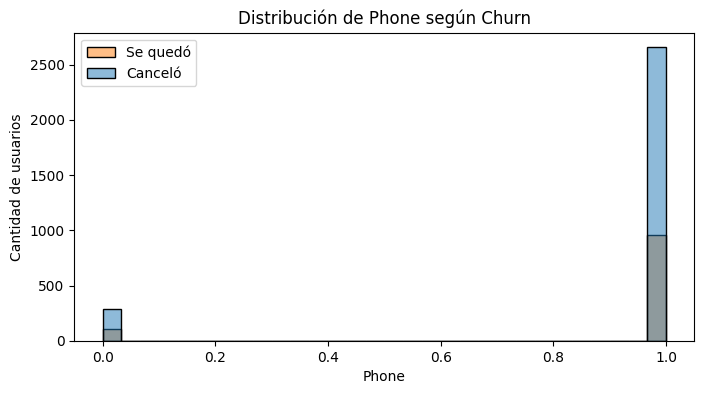

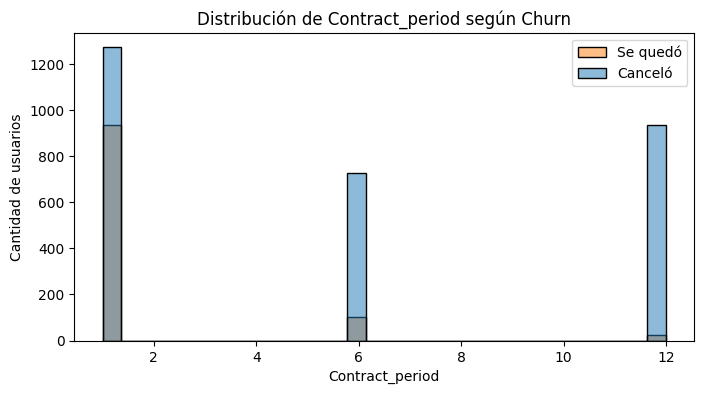

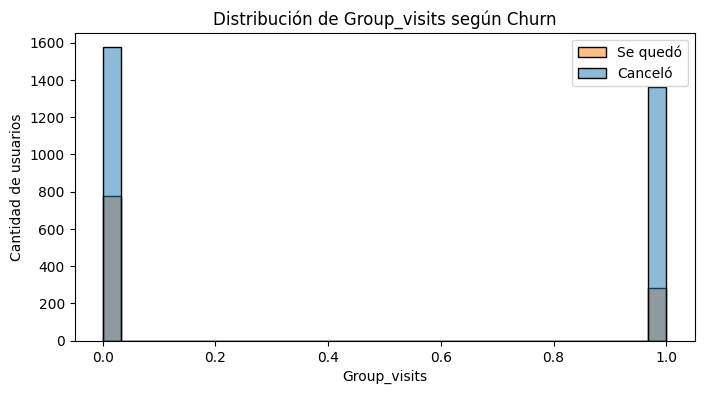

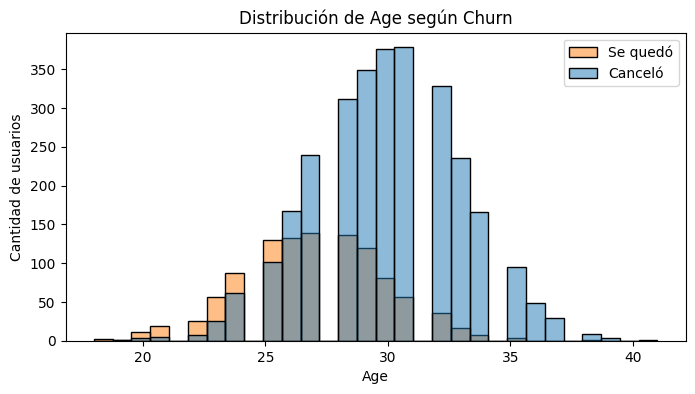

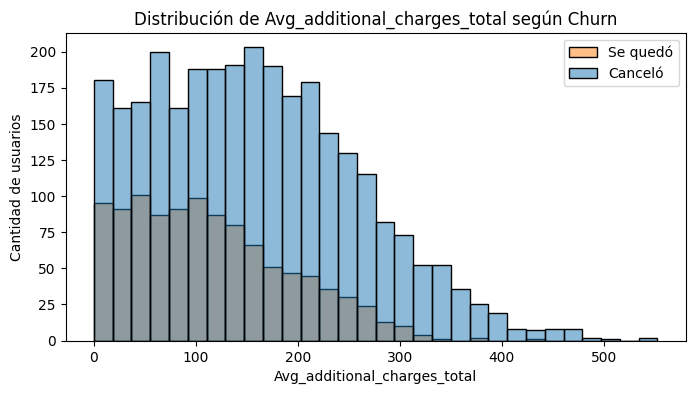

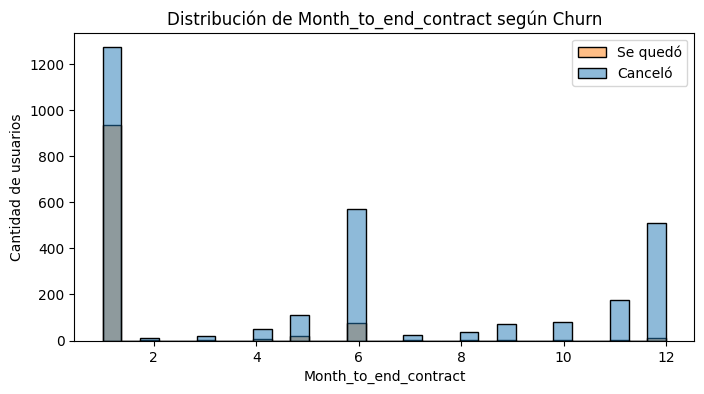

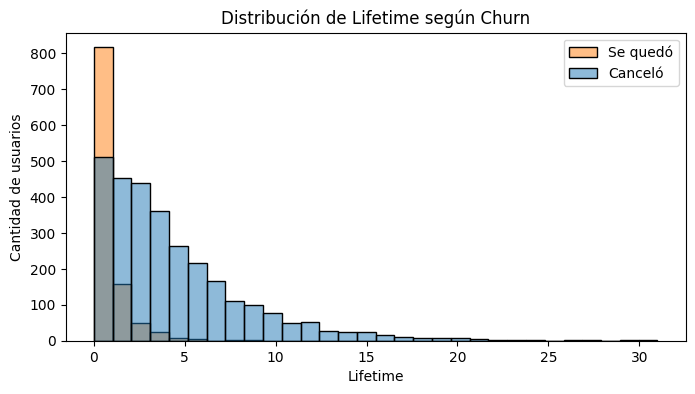

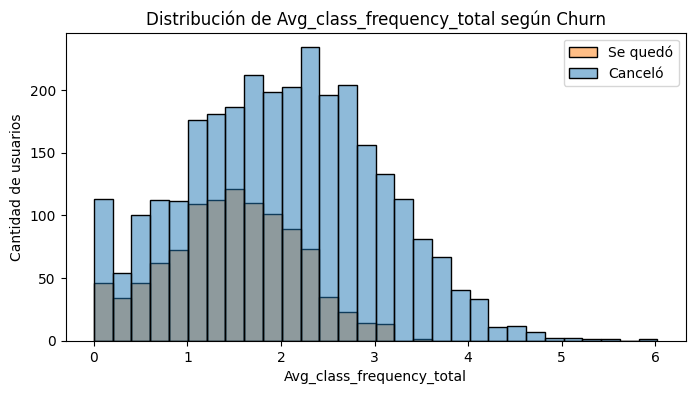

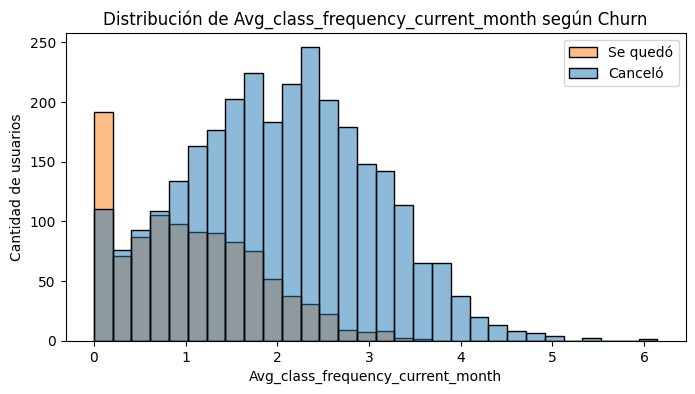

In [7]:
# Lista de columnas a graficar (omitimos Churn ya que es la variable objetivo)
features = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
            'Contract_period', 'Group_visits', 'Age', 'Avg_additional_charges_total',
            'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total',
            'Avg_class_frequency_current_month']

# Creamos histogramas para cada característica
for feature in features:
    plt.figure(figsize=(8,4))
    sns.histplot(data=data, x=feature, hue='Churn', kde=False, bins=30, alpha=0.5)
    plt.title(f'Distribución de {feature} según Churn')
    plt.xlabel(feature)
    plt.ylabel('Cantidad de usuarios')
    plt.legend(labels=['Se quedó','Canceló'])
    plt.show()

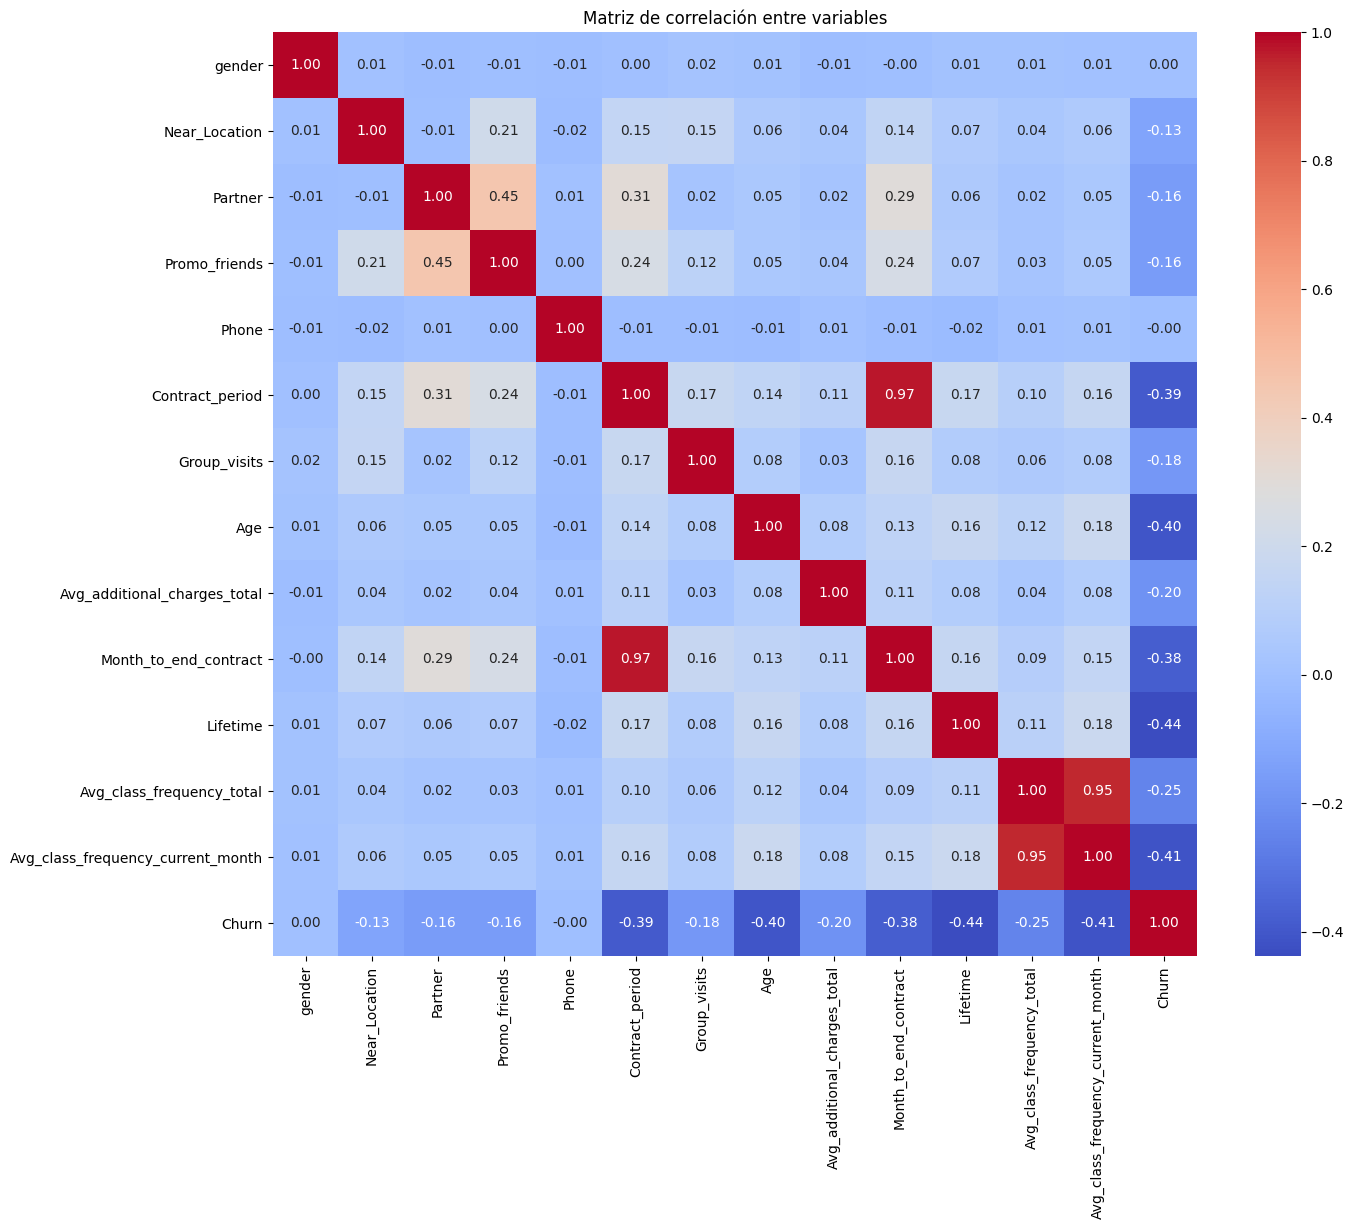

In [8]:

# Matriz de correlación
cm = data.corr()

# Visualización con heatmap
plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de correlación entre variables')
plt.show()



## Paso 3

In [9]:
# Variable objetivo
y = data['Churn']

# Variables de entrenamiento
X = data.drop('Churn', axis=1)

# Dividir en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,  random_state=0)

# Verificar tamaños
print("Tamaño X_train:", X_train.shape)
print("Tamaño X_val:", X_val.shape)
print("Tamaño y_train:", y_train.shape)
print("Tamaño y_val:", y_val.shape)

Tamaño X_train: (3200, 13)
Tamaño X_val: (800, 13)
Tamaño y_train: (3200,)
Tamaño y_val: (800,)


In [10]:


#Regresión logística
model = LogisticRegression(random_state = 0, max_iter=5000)
model.fit(X_train, y_train)
# Predicciones del modelo de regresión logística
y_probas = model.predict(X_val)
roc_log = roc_auc_score(y_val, y_probas)
print("ROC AUC Regresión Logística:", roc_log)

#Árbol de decisión
tree_model = DecisionTreeClassifier(random_state=0)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_val)
roc_tree = roc_auc_score(y_val, y_pred_tree)
print("ROC AUC Tree_model", roc_tree)

ROC AUC Regresión Logística: 0.8917161649719789
ROC AUC Tree_model 0.866631430584919


In [11]:


# calcular las métricas de clasificación

acc = accuracy_score(y_val, y_probas)
precision = precision_score(y_val, y_probas)
recall = recall_score(y_val, y_probas)

print("Regresión Logística:")
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)

# Predicciones árbol de decisión
accuracy_tree = accuracy_score(y_val, y_pred_tree)
precision_tree = precision_score(y_val, y_pred_tree)
recall_tree = recall_score(y_val, y_pred_tree)

print("\nÁrbol de Decisión:")
print("Accuracy:", accuracy_tree)
print("Precision:", precision_tree)
print("Recall:", recall_tree)

#Comparación
if roc_auc_score(y_val, model.predict_proba(X_val)[:,1]) > roc_auc_score(y_val, tree_model.predict_proba(X_val)[:,1]):
    print("\nEl modelo de regresión logística dio mejores resultados según ROC AUC.")
else:
    print("\nEl modelo de árbol de decisión dio mejores resultados según ROC AUC.")




Regresión Logística:
Accuracy: 0.92375
Precision: 0.8586387434554974
Recall: 0.8282828282828283

Árbol de Decisión:
Accuracy: 0.89875
Precision: 0.7910447761194029
Recall: 0.803030303030303

El modelo de regresión logística dio mejores resultados según ROC AUC.


## Paso 4

In [12]:
scaler = StandardScaler() 
scaler.fit(X)
X_sc = scaler.transform(X)

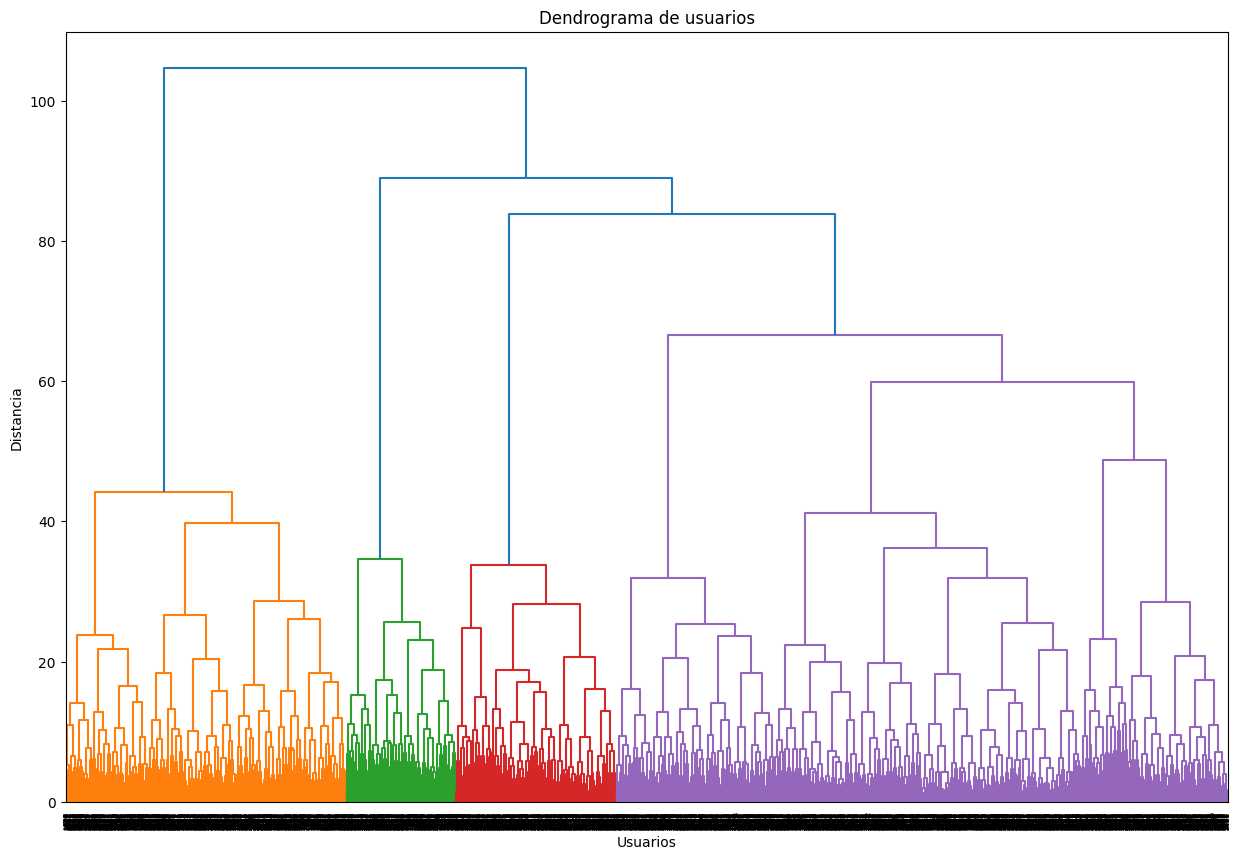

In [13]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Dendrograma de usuarios')
plt.xlabel('Usuarios')
plt.ylabel('Distancia')
plt.show()

Según el dendrograma utilizaremos 5 clusters

In [20]:
km = KMeans(n_clusters = 5)
labels = km.fit_predict(X_sc)
# predecimos los clústeres
clusters = km.predict(X_sc)

# agregamos los clústeres al dataframe original (sin la columna 'cancelación')
df_clusters = data.copy()
df_clusters['cluster'] = clusters

# mostramos cuántos usuarios hay en cada cluster
print(df_clusters['cluster'].value_counts())

2    1249
4    1010
1     851
3     505
0     385
Name: cluster, dtype: int64


In [22]:
# valores medios por cluster
cluster_means = df_clusters.groupby('cluster').mean()

print(cluster_means)

           gender  Near_Location   Partner  Promo_friends     Phone  \
cluster                                                               
0        0.522078       0.862338  0.470130       0.306494  0.000000   
1        0.561692       0.976498  0.352526       0.233843  0.998825   
2        0.484388       1.000000  0.352282       0.238591  1.000000   
3        0.495050       0.000000  0.463366       0.079208  1.000000   
4        0.501980       0.959406  0.784158       0.573267  1.000000   

         Contract_period  Group_visits        Age  \
cluster                                             
0               4.787013      0.425974  29.301299   
1               2.643948      0.470035  30.064630   
2               1.958367      0.341073  28.180945   
3               2.352475      0.215842  28.477228   
4              10.889109      0.544554  29.992079   

         Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster                                                 

Lo que más llama la atención:

Cluster 2 y 3 concentran el abandono: más del 51.5% y 44.3% de churn respectivamente.

Cluster 4 muestra contratos largos y visitas frecuentes.

Cluster 1 firman contratos cortos, son activos y gastan más.

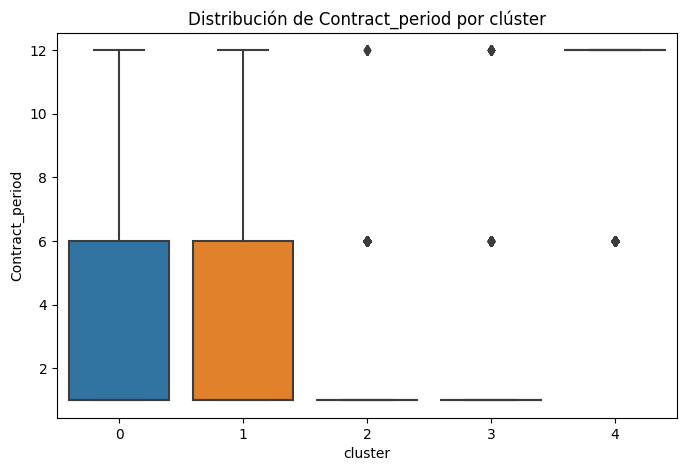

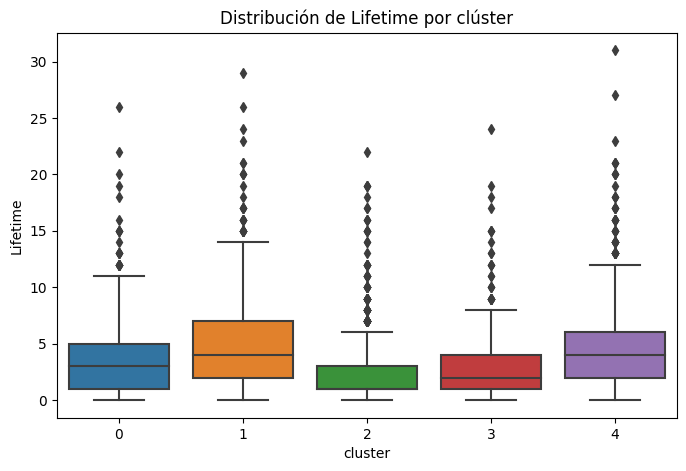

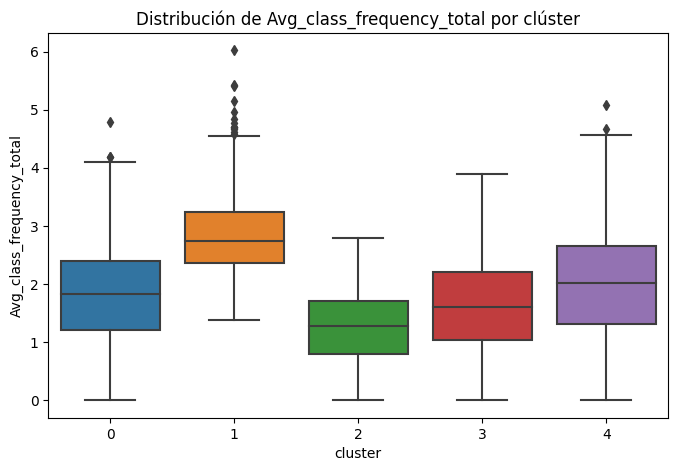

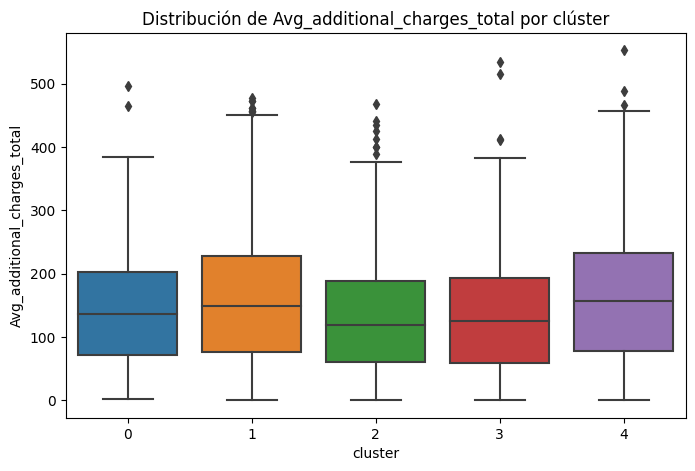

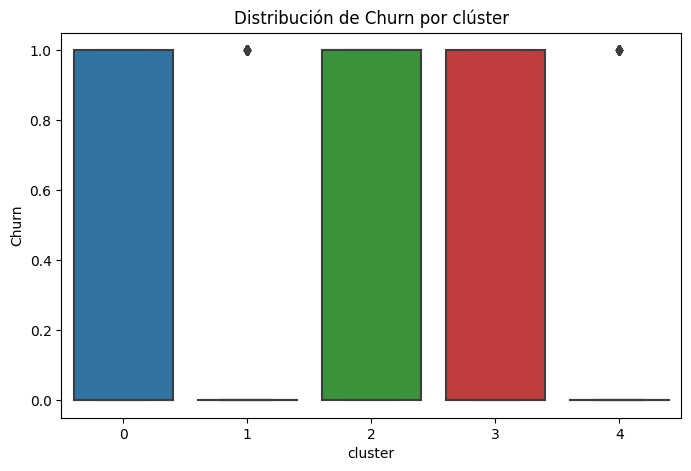

In [28]:

df_clusters["cluster"] = labels  # labels son los que devolvió KMeans


# recorremos algunas variables clave
features_to_plot = [
    "Contract_period",
    "Lifetime",
    "Avg_class_frequency_total",
    "Avg_additional_charges_total",
    "Churn"
]

for feature in features_to_plot:
    plt.figure(figsize=(8,5))
    sns.boxplot(x="cluster", y=feature, data=df_clusters)  
    plt.title(f"Distribución de {feature} por clúster")
    plt.show()


### Contract_period
Observamos un comportamiento similar en los clusteres 0 y 1 mientras que en los otros clusters observamos contratos muy cortos (1–2 meses) y otros muy largos(10–12 meses).

### Lifetime

Algunos clústeres concentran clientes que llevan poco tiempo, mientras que otros muestran usuarios que permanecieron varios meses más. Se observan muchos valores atipicos

### Avg_class_frequency_total

Se ve bastante variación. Hay clústeres que asisten con más frecuencia a clases, y otros que casi no lo hacen.

### Avg_additional_charges_total

Un par de clústeres tienen gastos adicionales más altos, lo que podría sugerir clientes más rentables.

### Churn
Mientras que los clusteres 0, 2 y 3 presentan churns más altos, los demás clusteres muestran una cancelación mucho menor.


In [30]:
# calcular tasa de cancelación por cluster
churn_rate = df_clusters.groupby("cluster")["Churn"].mean().reset_index()

# renombramos la columna para mayor claridad
churn_rate.columns = ["cluster", "churn_rate"]

print(churn_rate)

   cluster  churn_rate
0        0    0.267532
1        1    0.072855
2        2    0.515612
3        3    0.443564
4        4    0.027723


Los clusteres 1 y 4 muestran una mayor lealtad y mucha menor cancelación en comparación con los otros clusteres

## Paso 5

### Conclusiones

- Los clientes no son homogéneos y esto se evidencia en los comportamientos observados en cada uno de los clusters.
- Los clusters 1 y 4 presentan una lealtad mucho mayor en comparación a los demás.
- Dos clústeres presentan alto riesgo de abandono (clusters 2 y 3).

### Recomendaciones

- Ofertas para suscripciones o contratos más largos.

- Un servicio de acompañamiento al cliente, sobre todo si presentan comportamientos de tendencia al abandono.

- Realizar estudios para la apertura de nuevas sedes que permitan a más clientes tener un gimnasio en su vecindario.